# **Dependências do Projeto**

In [1]:
%pip install -U selenium

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: selenium in e:\anaconda3\lib\site-packages (4.8.2)



In [2]:
%pip install torch torchvision torchaudio
#Instalando o pytorch

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [4]:
#Caso não consiga pydirectinput
%pip install pyautogui

Note: you may need to restart the kernel to use updated packages.


In [5]:
#Biblioteca de aprendizado por reforço
%pip install stable-baselines3[extra] protobuf==3.20.*

Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install mss pydirectinput pytesseract

Note: you may need to restart the kernel to use updated packages.


# **Imports**

In [1]:
#Para captura de tela
from mss import mss
#import pyautogui #para comandos de teclado
import cv2 
#Tratamentos dos frames
import numpy as np 
import pyautogui
#Framework intermediário paara trabalhar com as imagens
#import pytesseract #para extrair o game over da imagem
from matplotlib import pyplot as plt #Visualizando resultados
import time
from PIL import Image
#Coisas para construir o ambinete
from gym import Env
from gym.spaces import Box, Discrete, Dict
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC
from io import BytesIO
from PIL import Image
from selenium.common.exceptions import WebDriverException
import base64
from io import BytesIO


# **Construindo o Ambiente**

In [2]:
from collections import deque

In [90]:
#Classe para definir o ambiente
class WebGame(Env):
    #ESSAS FUNÇÃO SÃO NECESSÁRIAS POR CONTA DO GYM
    #Função responsavel pela inicialização do ambiente;
    #Portanto onde ficam todas as variaveis do ambiente, configuração das ações e da observação 
    def __init__(self):
        super().__init__()

        #Configuração do tempo
        self.wait_time = .015
        
        #Configuração do espaço
        self.observation_space = Box(low=0, high=255, shape=(1,83,200), dtype=np.uint8)#Dict({
            #"print":Box(low=0, high=255, shape=(1,83,200), dtype=np.uint8),
            #"print2":Box(low=0, high=255, shape=(1,83,200), dtype=np.uint8),
            #"print3":Box(low=0, high=255, shape=(1,83,200), dtype=np.uint8),
            #"print4":Box(low=0, high=255, shape=(1,83,200), dtype=np.uint8),
            #"score":Box(low=0, high=10000, shape=(1,), dtype=np.uint8),
            #                          })
        self.action_space = Discrete(3)

        #Variavei para a captura de tela
        self.screen_cap = mss() #Lib de captura de tela
        self.game_location = {"top": 300, "left": 0, "width": 650, "height": 500} #Área do monitor com 
        self.game_done = {"top": 40, "left": 0, "width": 800, "height": 640}

        self.chromedriver_path = "./chromedriver.exe"
        _chrome_options = webdriver.ChromeOptions()
        _chrome_options.add_argument("--mute-audio")
        _chrome_options.add_argument("--disable-gpu")
        self._driver = webdriver.Chrome(executable_path=self.chromedriver_path,options=_chrome_options)

        self.first_image = np.zeros(5)
        self.last_image = np.zeros((500,650,3))
        
        #Dicionário de ações
        self.action_dict = {
            0:Keys.ARROW_DOWN,
            1:Keys.ARROW_UP,
            2:'nothing'
        }

    #Função responsavel por passar as ações pro jogo, para fazer algo pro jogo
    def step(self, action):
        # Se ação escolhida for um dos botões, realizar a ação.
        if action != 2:
            self._driver.find_elements(By.TAG_NAME, "body")[0].send_keys(self.action_dict[int(action)])
        
        #Checa a próxima ação
        observation = self.get_observation()
        #Todas as ações tem que verificar se a ação acabou
        done, done_cap = self.get_done() 
        
        #Pegando o score do jogo
        score = self.get_score()
        #Ganhamos 1 ponto por cada frame que estamos vivos.
        reward = 1
        #É um dicionário de informações que retornam através do que a gente precisa
        info = {
            'score':score
        }

        time.sleep(self.wait_time)
        
        return observation, reward, done, info
        

    #Função para a visualização do jogo:
    def render(self, mode: str='human'):
        img = cv2.cvtColor(self._get_image(), cv2.COLOR_BGR2RGB)
        if mode == 'rgb_array':
            return img
        elif mode == 'human':
            from gym.envs.classic_control import rendering
            if self.viewer is None:
                self.viewer = rendering.SimpleImageViewer()
            self.viewer.imshow(img)
            return self.viewer.isopen

        # cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     self.close()

    #Função responsavel por recomeçar o jogo
    def reset(self):
        #Try catch precisa existir pq toda a vez q o selenium detecta que ele viu o chrome dino,
        #ele dispara um erro que esta sem internet.
        try:
            self._driver.get('chrome://dino')
            
        except WebDriverException:
            pass
        WebDriverWait(self._driver, 10).until(
            EC.presence_of_element_located((
                By.CLASS_NAME, 
                "runner-canvas"
            ))
        )
        self._driver.implicitly_wait(0.5)
        self._driver.find_elements(By.TAG_NAME, "body")[0].send_keys(Keys.ARROW_UP)
        

        return self.get_observation()

    #FUNÇÕES CUSTOM
    #Fecha a parte de visualização
    def close(self):
        cv2.destroyAllWindows()
    
    def get_score(self):
        score_array = self._driver.execute_script("return Runner.instance_.distanceMeter.digits")
        score = ''.join(score_array)
        shape = np.zeros(1)
        shape[0] = int(score)
        return shape
    
    def get_img(self):
        LEADING_TEXT = "data:image/png;base64,"
        canvas = self._driver.execute_script("return document.querySelector('canvas.runner-canvas').toDataURL()")
        img = canvas[len(LEADING_TEXT):]
        img_data = np.array(Image.open(BytesIO(base64.b64decode(img))))
        return img_data 
        # img = self._driver.execute_script()
    
    #Função responsavel por pegar a imagem do jogo e tratar da forma necessária.
    def get_print(self): 

        #img = numpy.array(self.screen_cap.grab(game_location))[:,:,3].astype(np.uint8)
        raw = np.array(self.get_img())[:,:,:3].astype(np.uint8)
        img = raw[:200,:400]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (200,83))
        channel = np.reshape(resized, (1,83,200))
        
        self.first_image = self.last_image
        self.last_image = raw
        
        return channel
    
    #Função responsavel por pegar a imagem do jogo e tratar da forma necessária.
    def get_observation(self): 
        return self.get_print()#{"print":self.get_print(), "print2":self.get_print(), 
                #"print3":self.get_print(), "print4":self.get_print() 
                #"score":self.get_score()
               #}


    #Função para pegar o texto de fim de jogo:
    def get_done(self):
        #Se as duas imagens iniciais forem iguais acabou jogo
        done = False
        #Colando a primeira condição devido ao fator de que as formas diferentes estavam dando problema na comparação devido ao np.all
        
        if self.first_image.shape[0] != self.last_image.shape[0]:
            return done, self.last_image

        if np.all(np.equal(self.first_image, self.last_image)) and not self._driver.execute_script("return Runner.instance_.playing"):
            done = True
        
        return done, self.last_image

### Teste de Funções do Ambiente

In [47]:
env = WebGame()

C:\Users\Dan\AppData\Local\Temp\ipykernel_1552\2392320804.py:31: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  self._driver = webdriver.Chrome(executable_path=self.chromedriver_path,options=_chrome_options)


In [48]:
env.reset()

{'print': array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8),
 'print2': array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8),
 'print3': array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8),
 'print4': array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)}

In [26]:
#Teste para a captura de Imagem
teste = env.get_observation()

In [27]:
env.get_img().shape

(150, 600, 4)

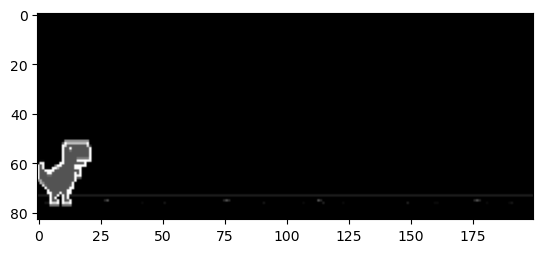

In [40]:
#Mostrando a imagem capturada
plt.imshow(cv2.cvtColor(np.reshape(teste['print'], (83, 200, 1)), cv2.COLOR_GRAY2BGR))

In [31]:
#Teste para ver se o jogo acaba
done, done_cap = env.get_done()
time.sleep(1)
done, done_cap = env.get_done()

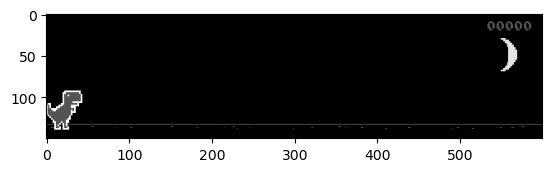

In [32]:
#Mostrando uma imagem de fim de jogo
plt.imshow(done_cap)

In [11]:
#10 partidas
for episode in range(10): 
    obs = env.reset()
    done = False  
    total_reward = 0
    while not done: 
        obs, reward,  done, info =  env.step(env.action_space.sample()) #
        total_reward  += reward
    print('Total Reward for episode {} is {} and the score is {}'.format(episode, total_reward,info['score']))   

Total Reward for episode 0 is 170 and the score is [91.]
Total Reward for episode 1 is 92 and the score is [46.]
Total Reward for episode 2 is 93 and the score is [46.]
Total Reward for episode 3 is 97 and the score is [46.]
Total Reward for episode 4 is 105 and the score is [56.]
Total Reward for episode 5 is 110 and the score is [57.]
Total Reward for episode 6 is 124 and the score is [64.]
Total Reward for episode 7 is 97 and the score is [46.]
Total Reward for episode 8 is 92 and the score is [47.]
Total Reward for episode 9 is 125 and the score is [68.]


# Treinamento

In [132]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Verificando se o ambiente é válido para fazer as coisa
from stable_baselines3.common import env_checker

from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv, SubprocVecEnv

In [133]:
#Criandos as pastas para que funcione.
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [134]:
env = WebGame()
env.reset()
# Verificando se o ambiente é válido para fazer as coisa
env_checker.check_env(env)

C:\Users\Dan\AppData\Local\Temp\ipykernel_1552\2064371905.py:31: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  self._driver = webdriver.Chrome(executable_path=self.chromedriver_path,options=_chrome_options)


In [136]:
model = PPO('CnnPolicy', env, verbose=2, 
            tensorboard_log=LOG_DIR, policy_kwargs=dict(normalize_images=False))
#model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=2, buffer_size=12000, 
#    learning_starts=500, policy_kwargs=dict(normalize_images=False))

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [137]:
#Salvando o modelo em uma pasta chamado de treino
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            if self.verbose >= 1:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Locals: {self.locals}")
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [138]:
callback = TrainAndLoggingCallback(check_freq=100, save_path=CHECKPOINT_DIR)

In [139]:
from stable_baselines3 import DQN, PPO, DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack,SubprocVecEnv
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results

In [71]:
env_lambda = lambda: WebGame()
env2 = SubprocVecEnv([env_lambda for i in range(4)])

In [23]:
env2.reset()

OrderedDict([('print',
              array([[[[0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       ...,
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0]]],
              
              
                     [[[0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       ...,
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0]]],
              
              
                     [[[0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       ...,
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
             

In [140]:
#Começa o treinamento
model.learn(total_timesteps=1000, log_interval=10, callback=callback)

Logging to ./logs/PPO_1
Num timesteps: 100
Locals: {'self': <stable_baselines3.ppo.ppo.PPO object at 0x00000196247FBEE0>, 'total_timesteps': 1000, 'callback': <__main__.TrainAndLoggingCallback object at 0x000001961ABF6130>, 'log_interval': 10, 'tb_log_name': 'PPO', 'reset_num_timesteps': True, 'progress_bar': False, 'iteration': 0, 'env': <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x000001962486A7F0>, 'rollout_buffer': <stable_baselines3.common.buffers.RolloutBuffer object at 0x000001961ABDB070>, 'n_rollout_steps': 2048, 'n_steps': 99, 'obs_tensor': tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8), 'actions': array([2], dtype=int64), 'values': tensor([[-15.3848]]), 'log_probs': tensor([-1.2464]), 'clipped_actions': array([2], dtype=int64), 'new_obs': array([[

Num timesteps: 800
Locals: {'self': <stable_baselines3.ppo.ppo.PPO object at 0x00000196247FBEE0>, 'total_timesteps': 1000, 'callback': <__main__.TrainAndLoggingCallback object at 0x000001961ABF6130>, 'log_interval': 10, 'tb_log_name': 'PPO', 'reset_num_timesteps': True, 'progress_bar': False, 'iteration': 0, 'env': <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x000001962486A7F0>, 'rollout_buffer': <stable_baselines3.common.buffers.RolloutBuffer object at 0x000001961ABDB070>, 'n_rollout_steps': 2048, 'n_steps': 799, 'obs_tensor': tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8), 'actions': array([0], dtype=int64), 'values': tensor([[60.3241]]), 'log_probs': tensor([-0.8638]), 'clipped_actions': array([0], dtype=int64), 'new_obs': array([[[[0, 0, 0, ..., 0, 0, 0]

Num timesteps: 1500
Locals: {'self': <stable_baselines3.ppo.ppo.PPO object at 0x00000196247FBEE0>, 'total_timesteps': 1000, 'callback': <__main__.TrainAndLoggingCallback object at 0x000001961ABF6130>, 'log_interval': 10, 'tb_log_name': 'PPO', 'reset_num_timesteps': True, 'progress_bar': False, 'iteration': 0, 'env': <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x000001962486A7F0>, 'rollout_buffer': <stable_baselines3.common.buffers.RolloutBuffer object at 0x000001961ABDB070>, 'n_rollout_steps': 2048, 'n_steps': 1499, 'obs_tensor': tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8), 'actions': array([1], dtype=int64), 'values': tensor([[4.4716]]), 'log_probs': tensor([-1.2190]), 'clipped_actions': array([1], dtype=int64), 'new_obs': array([[[[0, 0, 0, ..., 0, 0, 0

In [14]:
model.load('train/best_model_2000') 

# Teste

In [37]:
test_env = WebGame()
model = PPO('MultiInputPolicy', test_env, verbose=2)
model.load('train/best_model_1000') 
for episode in range(5): 
    obs = test_env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = test_env.step(action)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))

C:\Users\Dan\AppData\Local\Temp\ipykernel_19832\881399523.py:31: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  self._driver = webdriver.Chrome(executable_path=self.chromedriver_path,options=_chrome_options)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
0
0
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

0
0
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

0
0
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

1
1
<class 'numpy.ndarray'>
{0

1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
0
0
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

0
0
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

0
0
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: '

2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
0
0
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
0
0
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

0
0
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
2
2
<class 'numpy.ndarray'>
{0: '\ue015',

2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

0
0
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

0
0
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

0
0
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
2
2
<class 'numpy.ndarray'>
{0: '\ue015',

1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

0
0
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

0
0
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

1
1
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

0
0
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}

2
2
<class 'numpy.ndarray'>
{0: '\ue015', 1: '\ue013', 2: 'nothing'}
nothing
Total Reward for episode 4 is 92
